In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Adjacency Matricies

In [4]:
def random_connectivity_matrix(n, med_frac = 1.0, source_rate = 0.1, all_source_connections = 0, random_state = 10):
    rng = np.random.RandomState(random_state) # fixed random state
    
    A = rng.rand(n, n)
    A = np.dot(A.T, A)
    np.fill_diagonal(A, 0)
    K = A.copy()

    for i in range(n):
        loc_thresh = min(med_frac * np.median(A[i, 1:]), max(A[i, 1:] * 0.99))
        ind = A[i, 1:] < loc_thresh
        ind = np.insert(ind, 0, False)
        K[i, ind] = 0
        K[ind, i] = 0

    S = np.sum(K > 0.0, axis=0)
    for i in range(n):
        if S[i] == 0 or (i == 1 and S[i] < 2):
            if i != 1:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 1:]))
                K[i, ind + 1] = val
                K[ind + 1, i] = val
            else:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 2:]))
                K[i, ind + 2] = val
                K[ind + 2, i] = val

    K /= np.max(K)
    if all_source_connections:
        K[0, :] = source_rate
        K[:, 0] = source_rate
    else:
        K[0, :] = 0.0
        K[:, 0] = 0.0

    K[0, 1] = source_rate
    K[1, 0] = source_rate

    return K

def random_zero_diagonal_matrix(size, random_state = 10):
    """Generates an adjacency matrix with zero diagonal."""
    rng = np.random.RandomState(random_state) # fixed random state
    A = rng.rand(size, size)
    np.fill_diagonal(A, 0)
    return A

def binary_zero_diagonal_matrix(size):
    """Generates an adjacency matrix with zero diagonal."""
    A = np.ones([size, size])
    np.fill_diagonal(A, 0)
    return A

def tridiagonal_matrix(size):
    """Generates a binary tridiagonal adjacency matrix with zero diagonal."""
    A = np.zeros((size, size))
    np.fill_diagonal(A[:-1, 1:], 1)
    np.fill_diagonal(A[1:, :-1], 1)
    return A

def generate_laplacian_matrix(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

In [10]:
size = 3

A_random = random_connectivity_matrix(size)
print(f"random_connectivity_matrix:\n{A_random}")

A_random_zero_diag = random_zero_diagonal_matrix(size)
print(f"\nrandom_zero_diagonal_matrix:\n{A_random_zero_diag}")

A_binary_zero = binary_zero_diagonal_matrix(size)
print(f"\nbinary_zero_diagonal_matrix:\n{A_binary_zero}")

A_tridiagonal = tridiagonal_matrix(size)
print(f"\ntridiagonal_matrix:\n{A_tridiagonal}")

random_connectivity_matrix:
[[0.         0.1        0.        ]
 [0.1        0.         0.36270654]
 [0.         0.36270654 0.        ]]

random_zero_diagonal_matrix:
[[0.         0.57813643 0.85393375]
 [0.06809727 0.         0.78194912]
 [0.71860281 0.58602198 0.        ]]

binary_zero_diagonal_matrix:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]

tridiagonal_matrix:
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


### Compute Laplacian

In [13]:
def compute_laplacian(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

L_random = compute_laplacian(A_random)
print(f"random_connectivity_matrix:\n{L_random}")

L_random_zero_diag = compute_laplacian(A_random_zero_diag)
print(f"\nrandom_zero_diagonal_matrix:\n{L_random_zero_diag}")

L_binary_zero = compute_laplacian(A_binary_zero)
print(f"\nbinary_zero_diagonal_matrix:\n{L_binary_zero}")

L_tridiagonal = compute_laplacian(A_tridiagonal)
print(f"\ntridiagonal_matrix:\n{L_tridiagonal}")

random_connectivity_matrix:
[[ 0.1 -0.1  0. ]
 [-0.1  1.1 -1. ]
 [ 0.  -1.   1. ]]

random_zero_diagonal_matrix:
[[ 1.17989819 -0.29596171 -0.88393648]
 [-0.32551164  0.71804088 -0.39252924]
 [-0.09346037 -0.82110566  0.91456603]]

binary_zero_diagonal_matrix:
[[ 2. -1. -1.]
 [-1.  2. -1.]
 [-1. -1.  2.]]

tridiagonal_matrix:
[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]


### ACP Model

In [5]:
def acp_model(n_biomarker_stages, A, H, t_max=100, n_steps=200):
    n = n_biomarker_stages
    t = np.linspace(0, t_max, n_steps)
    dt = t[1] - t[0]
    x0 = np.zeros(n)
    x0[0] = 0.05
    
    k_ij = np.random.normal(loc=0.05, scale=1, size=n)
    gamma = np.ones(n) * 0.6
    eta = np.ones(n) * 0.9

    l1 = 3
    l2 = 3

    clip_min = -500
    clip_max = 500

    def acp_equations(f, A, H, k_ij, gamma, eta, l1, l2):
        exp_1 = np.clip(-l1 * (f - gamma), clip_min, clip_max)
        exp_2 = np.clip(l2 * (f - eta), clip_min, clip_max)
        
        K_ACP = k_ij / ((1 + np.exp(exp_1)) * (1 + np.exp(exp_2)))
        R_ACP = k_ij / (1 + np.exp(exp_2))
        dfdtau = np.dot((A * K_ACP), np.dot(H, f)) + R_ACP * f
        return dfdtau

    x = np.zeros((n, len(t)))
    x[:, 0] = x0

    for i in range(1, len(t)):
        dx_dt = acp_equations(x[:, i-1], A, H, k_ij, gamma, eta, l1, l2)
        x[:, i] = x[:, i-1] + dx_dt * dt
        x[:, i] = np.maximum(x[:, i], 0)

    return t, x

def plot_acp_results(t, x, matrix_type):
    for i in range(x.shape[0]):
        plt.plot(t, x[i], label=f'Biomarker {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title(f'ACP Model Simulation - {matrix_type}')
    plt.legend()
    plt.show()

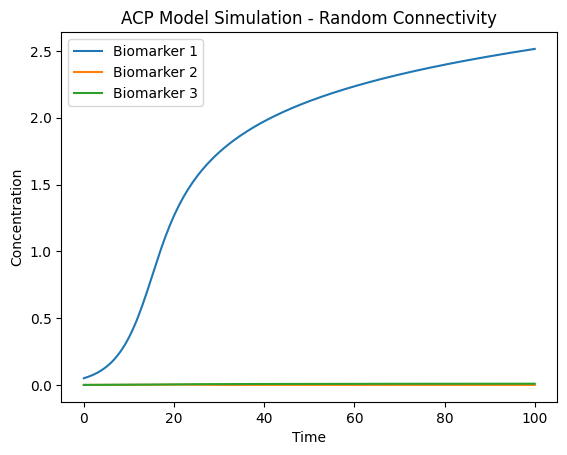

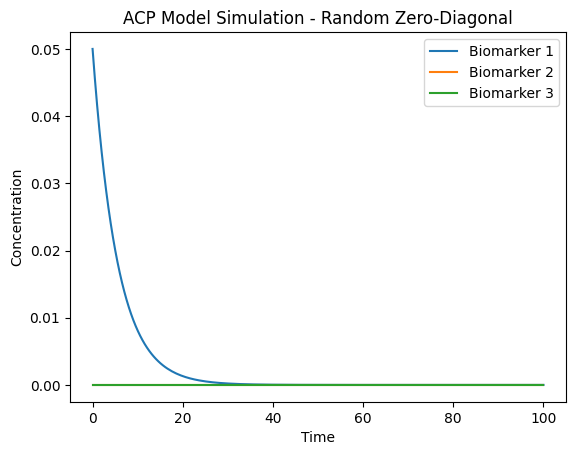

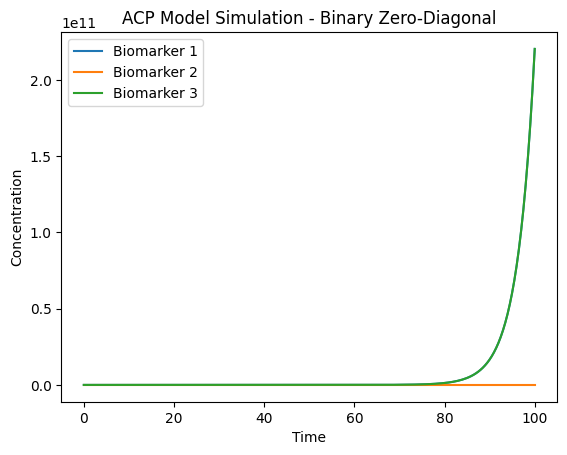

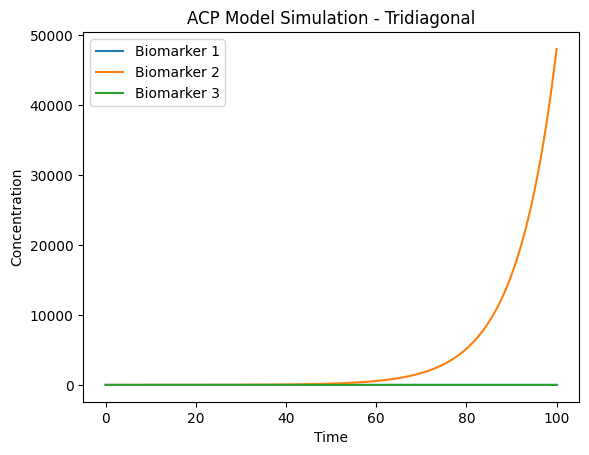

In [6]:
n_biomarker_stages = 3

# Random connectivity matrix
A_random = random_connectivity_matrix(n_biomarker_stages)
H_random = generate_laplacian_matrix(A_random)
t_random, x_random = acp_model(n_biomarker_stages, A_random, H_random)
plot_acp_results(t_random, x_random, 'Random Connectivity')

# Random zero-diagonal matrix
A_random_zero_diag = random_zero_diagonal_matrix(n_biomarker_stages)
H_random_zero_diag = generate_laplacian_matrix(A_random_zero_diag)
t_random_zero_diag, x_random_zero_diag = acp_model(n_biomarker_stages, A_random_zero_diag, H_random_zero_diag)
plot_acp_results(t_random_zero_diag, x_random_zero_diag, 'Random Zero-Diagonal')

# Binary zero-diagonal matrix
A_binary_zero = binary_zero_diagonal_matrix(n_biomarker_stages)
H_binary_zero = generate_laplacian_matrix(A_binary_zero)
t_binary_zero, x_binary_zero = acp_model(n_biomarker_stages, A_binary_zero, H_binary_zero)
plot_acp_results(t_binary_zero, x_binary_zero, 'Binary Zero-Diagonal')

# Tridiagonal matrix
A_tridiagonal = tridiagonal_matrix(n_biomarker_stages)
H_tridiagonal = generate_laplacian_matrix(A_tridiagonal)
t_tridiagonal, x_tridiagonal = acp_model(n_biomarker_stages, A_tridiagonal, H_tridiagonal)
plot_acp_results(t_tridiagonal, x_tridiagonal, 'Tridiagonal')
